In [3]:
!pip install opendatasets --upgrade --quiet

Setting up Flowers Database

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition/flowers'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  SherA200


Your Kaggle Key:

  ······


100%|██████████| 225M/225M [00:01<00:00, 168MB/s]  


In [5]:
import os

root_dir = './flowers-recognition'
data_dir = './flowers-recognition/flowers'
print(os.listdir(data_dir))

['daisy', 'dandelion', 'sunflower', 'tulip', 'rose']


In [6]:
import shutil
dup_dir = data_dir + '/flowers'
if os.path.exists(dup_dir) and os.path.isdir(dup_dir):
    shutil.rmtree(dup_dir)
print(os.listdir(data_dir))

['daisy', 'dandelion', 'sunflower', 'tulip', 'rose']


In [7]:
def rename_files(root_dir):
    classes = os.listdir(root_dir)
    for classes in classes:
        for file in os.listdir(root_dir + '/' + classes): 
            if file.endswith('jpg'):
                os.rename((root_dir + '/' + classes + '/' + file),(root_dir + '/' + classes + '/' + classes + "_" + file))

rename_files(data_dir)

Transformations

In [50]:
import torchvision.transforms as T

img_size = 64
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transform = T.Compose([T.Resize((img_size, img_size)),
                       T.RandomCrop(64, padding=4, padding_mode='reflect'),
                       T.RandomHorizontalFlip(),
                       T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       T.ToTensor(),
                       T.Normalize(*stats,inplace=True)])
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir, transform=transform)

In [ ]:
#showing original vs transformed image
from PIL import Image
image_path = '/kaggle/input/flowers-recognition/flowers/tulip/100930342_92e8746431_n.jpg'  # replace with your image path
image = Image.open(image_path)
transformed_image = transform(image)
transformed_pil_img = TF.to_pil_image(transformed_image)
plt.figure(figsize=(5, 5))
plt.title('Transformed Image')
plt.imshow(transformed_pil_img)
plt.axis('off')
plt.show()

In [51]:
len(dataset)

4317

In [52]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [53]:
from torch.utils.data import random_split

random_seed = 43
torch.manual_seed(random_seed)

val_pct = 0.15
test_pct = 0.15
val_size = int(val_pct * len(dataset))
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size

In [54]:
train_ds, valid_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(valid_ds), len(test_ds)

(3023, 647, 647)

In [55]:
from torch.utils.data import DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

In [56]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

Model Architecure

In [ ]:
class base_model(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding = 1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding = 1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding = 1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding = 1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding = 1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding = 1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding = 1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2)
 
    
        self.fc1 = nn.Linear(512, num_classes)

    def forward(self, xb):
        out = self.conv1_1(xb)
        out = self.bn1_1(out)
        out = self.relu1_1(out)
        out = self.conv1_2(out)
        out = self.bn1_2(out)
        out = self.relu1_2(out)
        out = self.pool1(out)
        
        out = self.conv2_1(out)
        out = self.bn2_1(out)
        out = self.relu2_1(out)
        out = self.conv2_2(out)
        out = self.bn2_2(out)
        out = self.relu2_2(out)
        out = self.pool2(out)

        out = self.conv3_1(out)
        out = self.bn3_1(out)
        out = self.relu3_1(out)
        out = self.conv3_2(out)
        out = self.bn3_2(out)
        out = self.relu3_2(out)
        out = self.pool3(out)

        out = self.conv4_1(out)
        out = self.bn4_1(out)
        out = self.relu4_1(out)
        out = self.conv4_2(out)
        out = self.bn4_2(out)
        out = self.relu4_2(out)
        out = self.pool4(out)

        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        return out


In [69]:
model = to_device(base_model(3, 5), device)
model

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Training and Testing

In [70]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs.append(model.validation_step((images, labels)))
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            loss = model.training_step((images, labels)) #batch
            train_losses.append(loss)
            loss.backward()
            
            # Optimization step
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [71]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6082912683486938, 'val_acc': 0.22057628631591797}]

Computational Experiment 1: Training Separate Models without Transfer Learning

In [72]:
epochs = 60
max_lr = 0.0001
opt_func = torch.optim.Adam

In [73]:
history+= fit(epochs, max_lr, model, train_dl, valid_dl, opt_func)

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.2161, val_loss: 1.1115, val_acc: 0.5588


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9975, val_loss: 1.0370, val_acc: 0.5960


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9131, val_loss: 0.8997, val_acc: 0.6311


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8662, val_loss: 0.9050, val_acc: 0.6599


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8375, val_loss: 0.9455, val_acc: 0.6270


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7882, val_loss: 0.8555, val_acc: 0.6802


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7155, val_loss: 1.1141, val_acc: 0.5885


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7244, val_loss: 0.7648, val_acc: 0.7167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6862, val_loss: 0.8331, val_acc: 0.7027


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6653, val_loss: 0.8438, val_acc: 0.6810


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6116, val_loss: 0.9270, val_acc: 0.6928


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6071, val_loss: 0.7525, val_acc: 0.7323


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5839, val_loss: 0.9311, val_acc: 0.6528


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5577, val_loss: 0.8572, val_acc: 0.7086


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5370, val_loss: 0.7778, val_acc: 0.7066


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5228, val_loss: 0.7448, val_acc: 0.7254


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5082, val_loss: 0.8518, val_acc: 0.7025


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4582, val_loss: 0.6985, val_acc: 0.7652


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4659, val_loss: 0.6647, val_acc: 0.7508


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4211, val_loss: 0.6762, val_acc: 0.7884


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3995, val_loss: 0.6473, val_acc: 0.7794


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3919, val_loss: 0.9836, val_acc: 0.7086


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.3911, val_loss: 0.8506, val_acc: 0.7039


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.3628, val_loss: 0.7197, val_acc: 0.7597


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.3511, val_loss: 1.0032, val_acc: 0.6841


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.3367, val_loss: 0.7542, val_acc: 0.7626


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.3078, val_loss: 0.6947, val_acc: 0.7908


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.3013, val_loss: 0.7439, val_acc: 0.7725


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.2885, val_loss: 0.7126, val_acc: 0.7638


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.2594, val_loss: 0.8608, val_acc: 0.7340


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.2754, val_loss: 0.8813, val_acc: 0.7399


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.2699, val_loss: 0.7238, val_acc: 0.7579


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.2591, val_loss: 0.9841, val_acc: 0.6838


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.2582, val_loss: 0.6964, val_acc: 0.7695


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.2352, val_loss: 0.6980, val_acc: 0.7683


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2320, val_loss: 1.2093, val_acc: 0.6398


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.2171, val_loss: 0.6354, val_acc: 0.7837


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.1901, val_loss: 0.7500, val_acc: 0.7695


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2047, val_loss: 0.8289, val_acc: 0.7323


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2579, val_loss: 0.8117, val_acc: 0.7352


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.2018, val_loss: 0.7375, val_acc: 0.7794


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.1621, val_loss: 0.8898, val_acc: 0.7397


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.1627, val_loss: 0.7232, val_acc: 0.7648


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1506, val_loss: 0.8097, val_acc: 0.7697


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1534, val_loss: 0.8059, val_acc: 0.7565


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1632, val_loss: 0.7657, val_acc: 0.7908


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1345, val_loss: 0.7375, val_acc: 0.7849


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1113, val_loss: 0.6962, val_acc: 0.8062


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1169, val_loss: 0.6570, val_acc: 0.8078


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1035, val_loss: 0.8368, val_acc: 0.7650


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.1134, val_loss: 0.8014, val_acc: 0.7908


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.1067, val_loss: 0.7045, val_acc: 0.8123


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.1085, val_loss: 0.6728, val_acc: 0.8095


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.1758, val_loss: 0.8060, val_acc: 0.7636


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.1291, val_loss: 0.8566, val_acc: 0.7537


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.1242, val_loss: 0.8117, val_acc: 0.7737


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.1266, val_loss: 0.7203, val_acc: 0.7924


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.1025, val_loss: 0.8124, val_acc: 0.7737


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0872, val_loss: 0.7189, val_acc: 0.7778


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0864, val_loss: 0.7517, val_acc: 0.8123


Plotting losses and accuracies over time

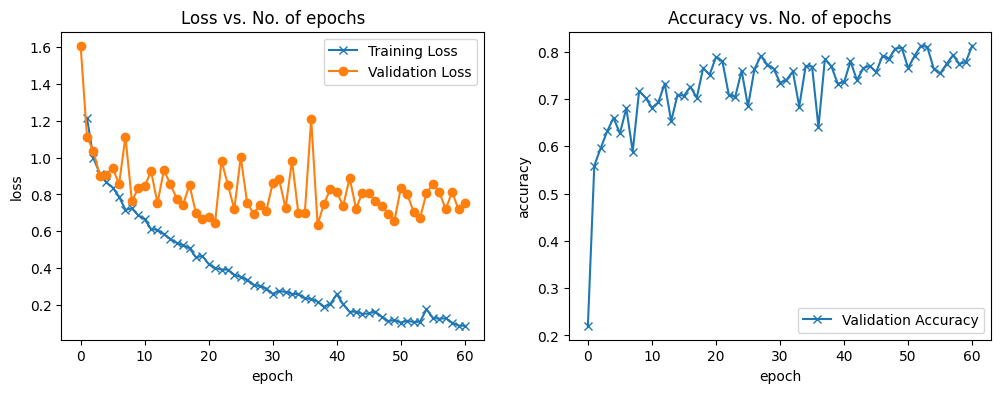

In [74]:
import matplotlib.pyplot as plt

def plot_history(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    accuracies = [x['val_acc'] for x in history]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, '-x', label='Training Loss')
    plt.plot(val_losses, '-o', label='Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, '-x', label='Validation Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of epochs')

plot_history(history)


In [75]:
history = [evaluate(model, test_dl)]
print(history)

[{'val_loss': 0.7896537780761719, 'val_acc': 0.7808441519737244}]


Setting up Indonesian Cuisine Dataset

In [20]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
data_dir_padang = "/kaggle/input/padangfood/dataset_padang_food"
dataset_padang = ImageFolder(root=data_dir_padang, transform=transform)
train_size_padang = int(0.7 * len(dataset_padang))
val_size_padang = int(0.15 * len(dataset_padang))
test_size_padang = len(dataset_padang) - train_size_padang - val_size_padang

train_ds_padang, val_ds_padang, test_ds_padang = random_split(dataset_padang, [train_size_padang, val_size_padang, test_size_padang])

from torch.utils.data import DataLoader

batch_size = 64

train_dl_padang = DataLoader(train_ds_padang, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl_padang = DataLoader(val_ds_padang, batch_size, num_workers=3, pin_memory=True)
test_dl_padang = DataLoader(test_ds_padang, batch_size, num_workers=3, pin_memory=True)

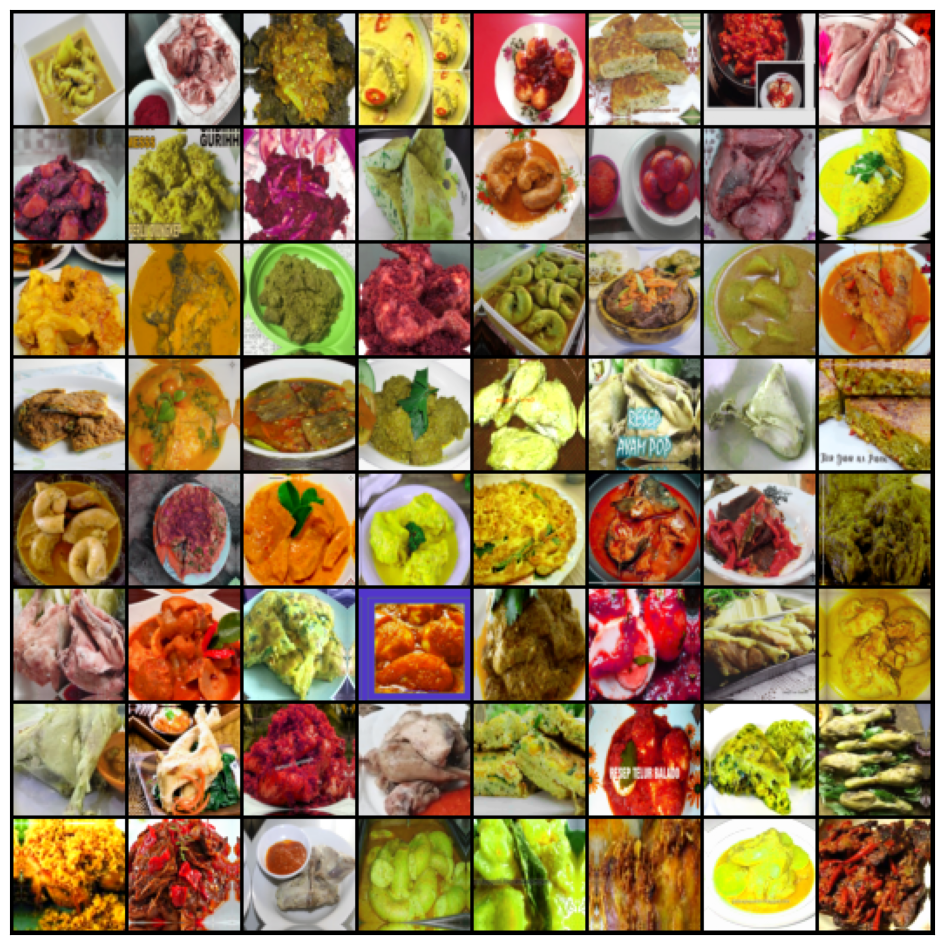

In [21]:
show_batch(train_dl_padang)

In [22]:
device_padang = get_default_device()
device_padang
train_dl_padang = DeviceDataLoader(train_dl_padang, device_padang)
val_dl_padang = DeviceDataLoader(val_dl_padang, device_padang)
test_dl_padang = DeviceDataLoader(test_dl_padang, device_padang)

In [42]:
model_padang = to_device(base_model(3, 9), device_padang)
model_padang

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Training and Testing 

In [43]:
history_padang = [evaluate(model_padang, val_dl_padang)]
history_padang

[{'val_loss': 2.1945996284484863, 'val_acc': 0.1666666716337204}]

Training new model on indonesian food dataset(No transfer learning)

In [44]:
epochs_padang = 60
max_lr_padang = 0.0001
opt_func_padang = torch.optim.Adam

In [45]:
history_padang += fit(epochs_padang, max_lr_padang, model_padang, train_dl_padang, val_dl_padang, opt_func_padang)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.9281, val_loss: 2.2755, val_acc: 0.2104


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.5497, val_loss: 2.7501, val_acc: 0.2083


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.4665, val_loss: 2.0615, val_acc: 0.3052


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.3842, val_loss: 1.3196, val_acc: 0.5156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.2666, val_loss: 1.2715, val_acc: 0.5365


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.2012, val_loss: 1.1458, val_acc: 0.5823


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1908, val_loss: 1.2149, val_acc: 0.5479


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.1230, val_loss: 1.1371, val_acc: 0.5771


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.0542, val_loss: 1.2497, val_acc: 0.5229


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.0377, val_loss: 1.4057, val_acc: 0.5167


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.9982, val_loss: 1.2532, val_acc: 0.5760


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.9107, val_loss: 1.0672, val_acc: 0.6250


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.8410, val_loss: 1.3106, val_acc: 0.4875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7827, val_loss: 1.3938, val_acc: 0.5479


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.8073, val_loss: 1.1667, val_acc: 0.6219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.7796, val_loss: 1.1128, val_acc: 0.6062


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6763, val_loss: 0.9915, val_acc: 0.6646


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6823, val_loss: 0.8978, val_acc: 0.6333


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6326, val_loss: 1.1558, val_acc: 0.5906


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.6291, val_loss: 0.9970, val_acc: 0.5792


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.5982, val_loss: 0.9341, val_acc: 0.5938


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.5290, val_loss: 1.4635, val_acc: 0.4771


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.5271, val_loss: 1.1002, val_acc: 0.6490


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.5268, val_loss: 0.9143, val_acc: 0.6969


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4826, val_loss: 1.0826, val_acc: 0.6552


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4849, val_loss: 1.0726, val_acc: 0.6719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.3902, val_loss: 1.0517, val_acc: 0.6208


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.3875, val_loss: 1.1506, val_acc: 0.6635


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.3644, val_loss: 1.0805, val_acc: 0.6927


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.3282, val_loss: 1.0223, val_acc: 0.6427


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.3113, val_loss: 1.1864, val_acc: 0.6219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.3458, val_loss: 1.0625, val_acc: 0.6677


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.3469, val_loss: 1.3187, val_acc: 0.5781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.3319, val_loss: 0.9100, val_acc: 0.7625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.2759, val_loss: 1.1899, val_acc: 0.6365


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2691, val_loss: 1.1540, val_acc: 0.7031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.2640, val_loss: 1.3763, val_acc: 0.5677


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2635, val_loss: 1.0756, val_acc: 0.6979


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2522, val_loss: 1.1031, val_acc: 0.6708


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2235, val_loss: 1.1484, val_acc: 0.6219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.2344, val_loss: 1.1216, val_acc: 0.6000


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.2630, val_loss: 1.1290, val_acc: 0.6500


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.2014, val_loss: 1.5363, val_acc: 0.6073


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.2035, val_loss: 0.8885, val_acc: 0.7063


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.2106, val_loss: 1.0527, val_acc: 0.6479


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.2139, val_loss: 0.9628, val_acc: 0.7250


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1677, val_loss: 0.7611, val_acc: 0.7562


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1592, val_loss: 1.1745, val_acc: 0.6906


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1747, val_loss: 1.0845, val_acc: 0.6656


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1476, val_loss: 0.9147, val_acc: 0.7198


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.1333, val_loss: 1.0534, val_acc: 0.6802


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.1426, val_loss: 1.1482, val_acc: 0.7083


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.1257, val_loss: 1.0938, val_acc: 0.6792


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.1398, val_loss: 0.9393, val_acc: 0.7188


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.1280, val_loss: 0.9659, val_acc: 0.7365


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.1313, val_loss: 0.7261, val_acc: 0.7615


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.1125, val_loss: 1.1792, val_acc: 0.6823


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.1089, val_loss: 1.2644, val_acc: 0.6469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0958, val_loss: 1.0880, val_acc: 0.7135


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0898, val_loss: 1.2203, val_acc: 0.6740


In [58]:
history_padang_test = [evaluate(model_padang, test_dl_padang)]
print(history_padang_test)

[{'val_loss': 0.8158484697341919, 'val_acc': 0.6808711886405945}]


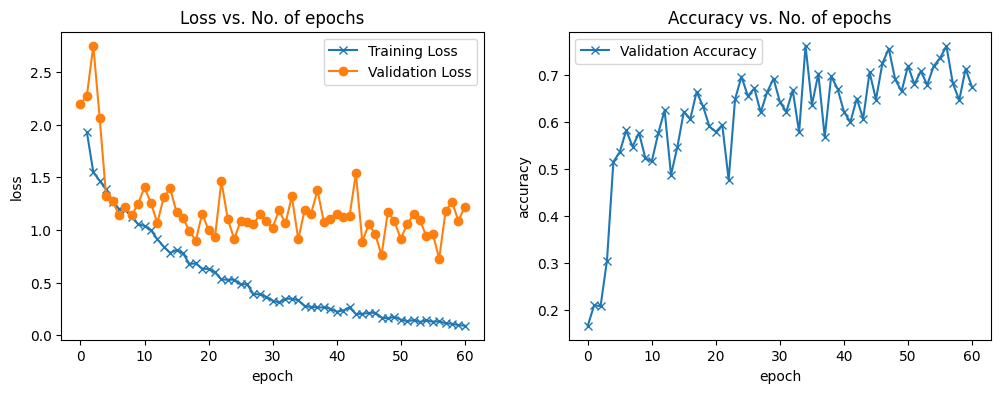

In [59]:
plot_history(history_padang)

Setting up Fruits dataset

In [89]:
data_dir_new_veg = '/kaggle/input/fruits-dataset-images/images'
dataset_new_veg = ImageFolder(root=data_dir_new_veg, transform=transform)

In [91]:

from torch.utils.data import DataLoader

batch_size = 64

train_dl_new_veg = DataLoader(train_ds_new_veg, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl_new_veg = DataLoader(valid_ds_new_veg, batch_size, num_workers=3, pin_memory=True)
test_dl_new_veg = DataLoader(valid_ds_new_veg, batch_size, num_workers=3, pin_memory=True)

In [90]:
from torch.utils.data import random_split

random_seed = 43
torch.manual_seed(random_seed)

val_pct_new_veg = 0.15
test_pct_new_veg = 0.15
val_size_new_veg = int(val_pct_new_veg * len(dataset_new_veg))
test_size_new_veg = int(test_pct_new_veg * len(dataset_new_veg))
train_size_new_veg = len(dataset_new_veg) - val_size_new_veg - test_size_new_veg
train_ds_new_veg, valid_ds_new_veg, test_ds_new_veg = random_split(dataset_new_veg, [train_size_new_veg, val_size_new_veg, test_size_new_veg])
len(train_ds_new_veg), len(valid_ds_new_veg), len(test_ds_new_veg)

(253, 53, 53)

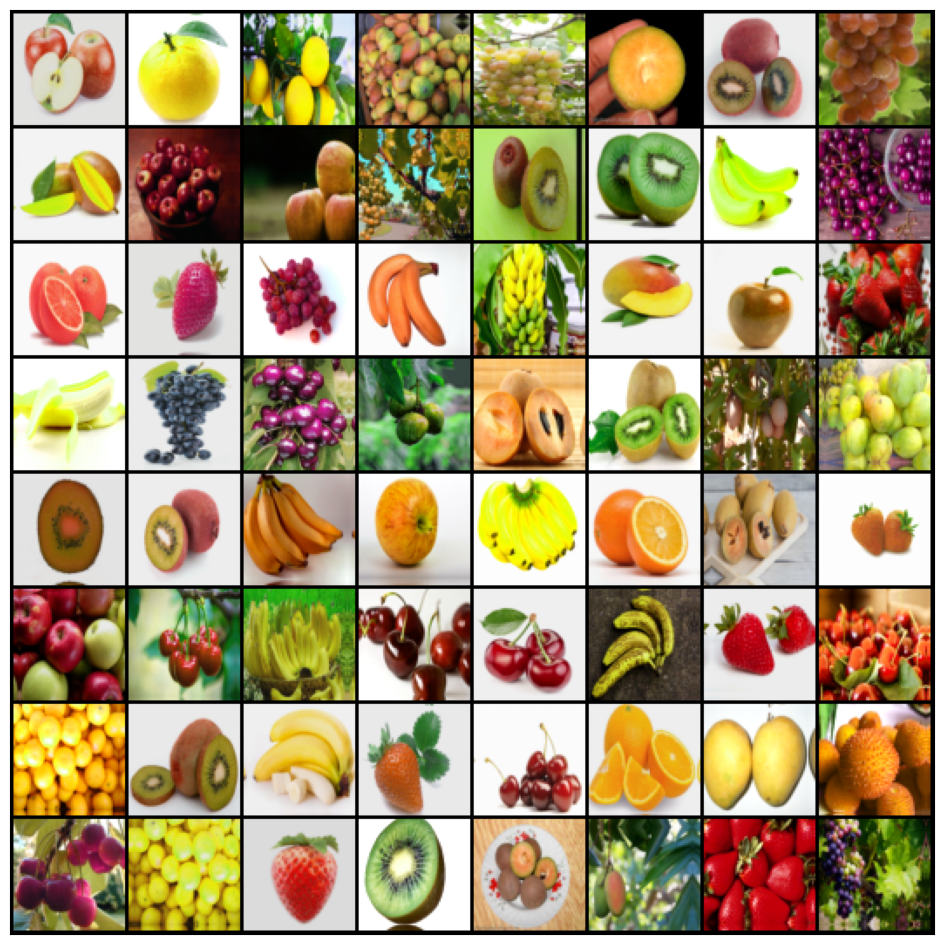

In [92]:
show_batch(train_dl_new_veg)

In [93]:
device_new_veg = get_default_device()
device_new_veg
train_dl_new_veg = DeviceDataLoader(train_dl_new_veg, device_new_veg)
valid_dl_new_veg = DeviceDataLoader(valid_dl_new_veg, device_new_veg)
test_dl_new_veg = DeviceDataLoader(test_dl_new_veg, device_new_veg)

In [99]:
model_new_veg = to_device(base_model(3, 9), device_new_veg)
model_new_veg

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Training and Testing

In [100]:
epochs_new_veg = 60
max_lr_new_veg = 0.0001
opt_func_new_veg = torch.optim.Adam

In [101]:
history_new_veg = [evaluate(model_new_veg, valid_dl_new_veg)]
history_new_veg

[{'val_loss': 2.1972203254699707, 'val_acc': 0.03773584961891174}]

Training new model on fruits dataset(No transfer learning)

In [102]:
history_new_veg += fit(epochs_new_veg, max_lr_new_veg, model_new_veg, train_dl_new_veg, valid_dl_new_veg, opt_func_new_veg)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.0250, val_loss: 2.1982, val_acc: 0.1321


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.5630, val_loss: 2.2206, val_acc: 0.1321


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.4913, val_loss: 2.2847, val_acc: 0.1509


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.3616, val_loss: 2.3906, val_acc: 0.1509


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.2919, val_loss: 2.5142, val_acc: 0.1509


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.1816, val_loss: 2.5625, val_acc: 0.2075


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1288, val_loss: 2.5747, val_acc: 0.2453


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.0972, val_loss: 2.4561, val_acc: 0.1887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.9503, val_loss: 2.0615, val_acc: 0.3208


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.9232, val_loss: 1.9534, val_acc: 0.3396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.8591, val_loss: 1.4199, val_acc: 0.5094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.7786, val_loss: 1.1879, val_acc: 0.5094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.7456, val_loss: 1.4612, val_acc: 0.4717


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7491, val_loss: 1.1362, val_acc: 0.5472


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6627, val_loss: 1.1569, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6193, val_loss: 1.4863, val_acc: 0.5094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5940, val_loss: 1.2054, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6098, val_loss: 1.1921, val_acc: 0.5849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5538, val_loss: 1.0930, val_acc: 0.6038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5631, val_loss: 1.2415, val_acc: 0.6038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4743, val_loss: 1.1589, val_acc: 0.5849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4641, val_loss: 1.1036, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4693, val_loss: 1.1655, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4259, val_loss: 1.3667, val_acc: 0.5849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4185, val_loss: 1.2472, val_acc: 0.5283


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.3846, val_loss: 1.1215, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.3580, val_loss: 1.1770, val_acc: 0.6038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.3576, val_loss: 1.2355, val_acc: 0.5660


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.3859, val_loss: 1.0110, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.3715, val_loss: 1.0301, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.3322, val_loss: 1.3342, val_acc: 0.5660


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.3315, val_loss: 1.0690, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.3402, val_loss: 1.5043, val_acc: 0.5094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.2652, val_loss: 1.2055, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.2969, val_loss: 1.1638, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2458, val_loss: 1.1445, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.1927, val_loss: 0.9434, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2629, val_loss: 1.1805, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.1799, val_loss: 1.0355, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.1944, val_loss: 1.0457, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.1763, val_loss: 1.0200, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.1656, val_loss: 1.1025, val_acc: 0.6792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.1648, val_loss: 0.8451, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1394, val_loss: 1.0102, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1320, val_loss: 1.0271, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1239, val_loss: 0.8696, val_acc: 0.7547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1444, val_loss: 1.5405, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1477, val_loss: 1.1491, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1196, val_loss: 1.2124, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1318, val_loss: 1.0085, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.0975, val_loss: 1.1711, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.1158, val_loss: 1.1014, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.1073, val_loss: 1.2166, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.1124, val_loss: 1.2712, val_acc: 0.5660


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.1319, val_loss: 1.3402, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.0939, val_loss: 1.2075, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.1004, val_loss: 1.4037, val_acc: 0.6038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.1185, val_loss: 1.4402, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.1126, val_loss: 0.9399, val_acc: 0.7925


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.1067, val_loss: 0.9249, val_acc: 0.6981


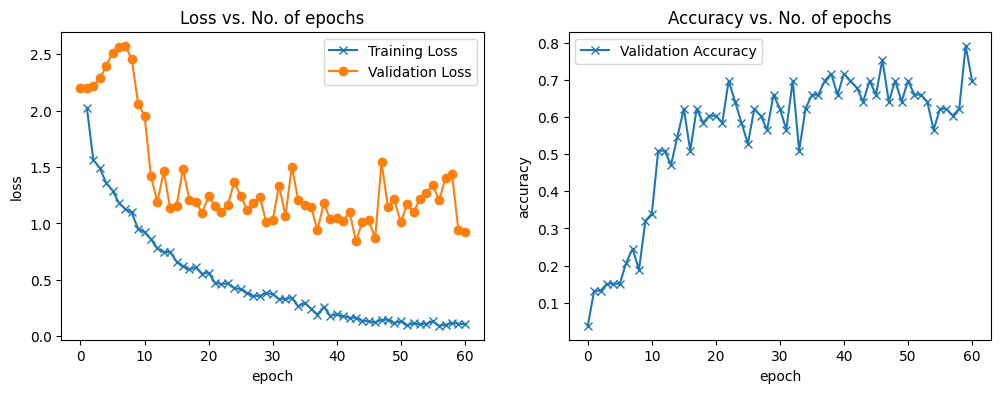

In [103]:
plot_history(history_new_veg)

In [105]:
history_new_veg_test = [evaluate(model_new_veg, test_dl_new_veg)]
print(history_new_veg_test)

[{'val_loss': 1.0713517665863037, 'val_acc': 0.6037735939025879}]


Computational Experiment #2: Improving Model Accuracy with Transfer Learning

Transfer Learning from Flowers to Indonesian Cuisine


In [60]:
data_dir_transfer_padang = "./flowers-recognition/flowers"


dataset_transfer_padang = ImageFolder(root=data_dir_transfer_padang, transform=transform)

In [61]:
random_seed = 43
torch.manual_seed(random_seed)

val_pct_transfer_padang = 0.15
test_pct_transfer_padang = 0.15
val_size_transfer_padang = int(val_pct_transfer_padang * len(dataset_transfer_padang))
test_size_transfer_padang = int(test_pct_transfer_padang * len(dataset_transfer_padang))
train_size_transfer_padang = len(dataset_transfer_padang) - val_size_transfer_padang - test_size_transfer_padang
train_ds_transfer_padang, valid_ds_transfer_padang, test_ds_transfer_padang = random_split(dataset_transfer_padang, [train_size_transfer_padang, val_size_transfer_padang, test_size_transfer_padang])
len(train_ds_transfer_padang), len(valid_ds_transfer_padang), len(test_ds_transfer_padang)
from torch.utils.data import DataLoader

batch_size = 64

train_dl_transfer_padang = DataLoader(train_ds_transfer_padang, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl_transfer_padang = DataLoader(valid_ds_transfer_padang, batch_size, num_workers=3, pin_memory=True)
test_dl_transfer_padang = DataLoader(valid_ds_transfer_padang, batch_size, num_workers=3, pin_memory=True)

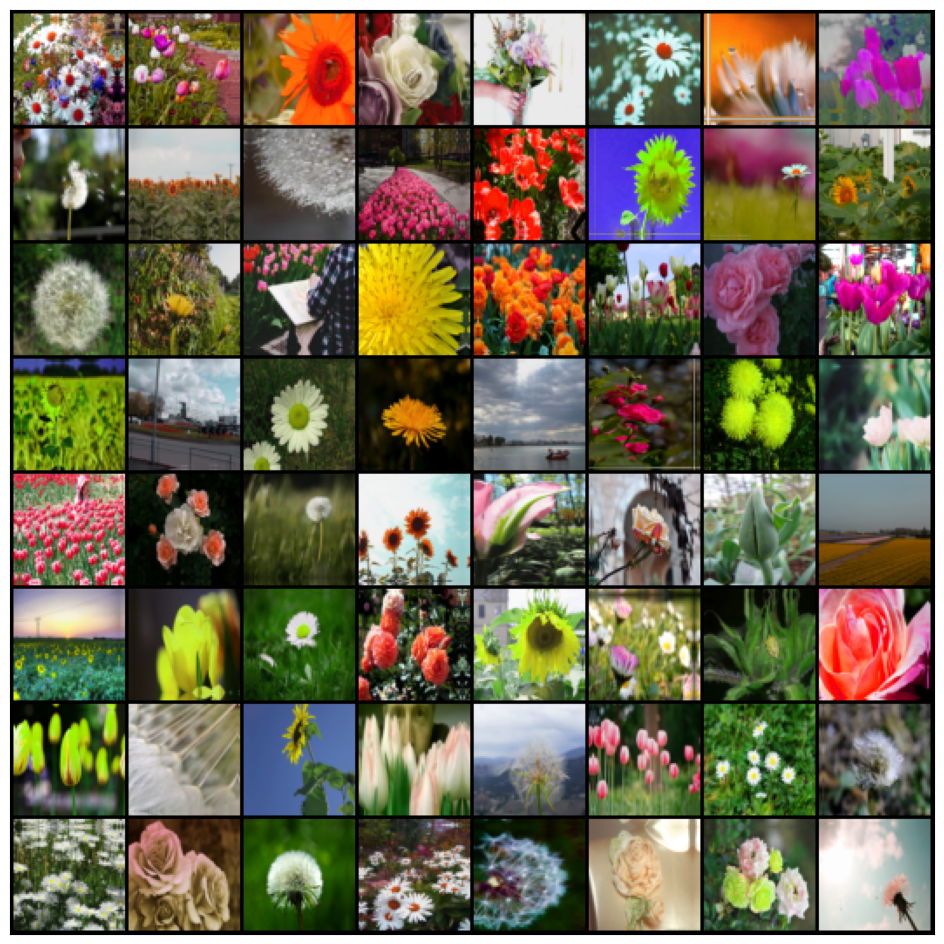

In [62]:
show_batch(train_dl_transfer_padang)

In [63]:
train_dl_transfer_padang = DeviceDataLoader(train_dl_transfer_padang, get_default_device())
valid_dl_transfer_padang = DeviceDataLoader(valid_dl_transfer_padang, get_default_device())
test_dl_transfer_padang = DeviceDataLoader(test_dl_transfer_padang, get_default_device())

In [72]:
model_transfer_padang = to_device(base_model(3, 5), device)
model_transfer_padang

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Initial training on Flowers dataset

In [73]:
epochs_transfer_padang = 60
max_lr_transfer_padang = 0.0001
opt_func_transfer_padang = torch.optim.Adam

In [74]:
history_transfer_padang = [evaluate(model_transfer_padang, valid_dl_transfer_padang)]
history_transfer_padang

[{'val_loss': 1.6144427061080933, 'val_acc': 0.15767045319080353}]

Training new model on flowers dataset(will be used for indonesian food dataset)

In [75]:
history_transfer_padang += fit(epochs_transfer_padang, max_lr_transfer_padang, model_transfer_padang, train_dl_transfer_padang, valid_dl_transfer_padang, opt_func_transfer_padang)

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1687, val_loss: 1.1013, val_acc: 0.5515


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9769, val_loss: 1.0134, val_acc: 0.5643


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9058, val_loss: 0.9398, val_acc: 0.6171


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8522, val_loss: 0.8991, val_acc: 0.6656


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7826, val_loss: 0.8642, val_acc: 0.6700


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7373, val_loss: 0.9999, val_acc: 0.6528


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7165, val_loss: 0.8860, val_acc: 0.6658


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6853, val_loss: 0.8215, val_acc: 0.6812


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6752, val_loss: 0.8661, val_acc: 0.6353


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6277, val_loss: 1.0301, val_acc: 0.6445


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5971, val_loss: 0.7886, val_acc: 0.7397


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5840, val_loss: 1.2005, val_acc: 0.6004


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5487, val_loss: 0.7848, val_acc: 0.7285


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5362, val_loss: 0.9857, val_acc: 0.7070


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5051, val_loss: 0.7412, val_acc: 0.7455


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4990, val_loss: 0.7224, val_acc: 0.7267


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4565, val_loss: 0.7418, val_acc: 0.7169


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4573, val_loss: 0.6948, val_acc: 0.7695


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4313, val_loss: 0.7968, val_acc: 0.7183


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4287, val_loss: 0.7065, val_acc: 0.7293


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3643, val_loss: 1.1761, val_acc: 0.6698


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3926, val_loss: 0.9453, val_acc: 0.6528


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.3682, val_loss: 0.6305, val_acc: 0.7865


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.3351, val_loss: 0.9205, val_acc: 0.6912


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.3410, val_loss: 1.0839, val_acc: 0.6798


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.3136, val_loss: 0.8831, val_acc: 0.7512


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.3077, val_loss: 0.8486, val_acc: 0.7368


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.2695, val_loss: 0.7078, val_acc: 0.7780


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.2753, val_loss: 0.7662, val_acc: 0.7466


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.2777, val_loss: 0.8426, val_acc: 0.7441


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.2600, val_loss: 0.6585, val_acc: 0.7837


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.2531, val_loss: 0.9471, val_acc: 0.6879


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.2368, val_loss: 0.7180, val_acc: 0.7766


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.2330, val_loss: 1.0459, val_acc: 0.7096


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.2119, val_loss: 1.1089, val_acc: 0.6885


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2021, val_loss: 0.6846, val_acc: 0.7867


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.1975, val_loss: 0.7249, val_acc: 0.7581


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.1927, val_loss: 0.8292, val_acc: 0.7468


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2644, val_loss: 0.8508, val_acc: 0.7397


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2035, val_loss: 0.8362, val_acc: 0.7553


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.1738, val_loss: 0.7698, val_acc: 0.7683


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.1509, val_loss: 1.3592, val_acc: 0.6654


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.1437, val_loss: 0.8156, val_acc: 0.7539


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1395, val_loss: 0.7345, val_acc: 0.7666


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1563, val_loss: 1.2085, val_acc: 0.7141


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1469, val_loss: 0.7553, val_acc: 0.7752


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1440, val_loss: 0.6294, val_acc: 0.8151


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1179, val_loss: 0.8822, val_acc: 0.7612


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1038, val_loss: 0.7623, val_acc: 0.7823


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1131, val_loss: 0.7606, val_acc: 0.7707


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.1333, val_loss: 0.8667, val_acc: 0.7583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.1136, val_loss: 0.9478, val_acc: 0.7537


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.1204, val_loss: 0.9169, val_acc: 0.7480


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.0972, val_loss: 0.7450, val_acc: 0.7910


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.0949, val_loss: 0.7024, val_acc: 0.7879


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.1239, val_loss: 0.8139, val_acc: 0.7650


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.1373, val_loss: 0.8391, val_acc: 0.7494


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.1011, val_loss: 0.7165, val_acc: 0.7780


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0762, val_loss: 0.6216, val_acc: 0.8091


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0743, val_loss: 0.7111, val_acc: 0.8007


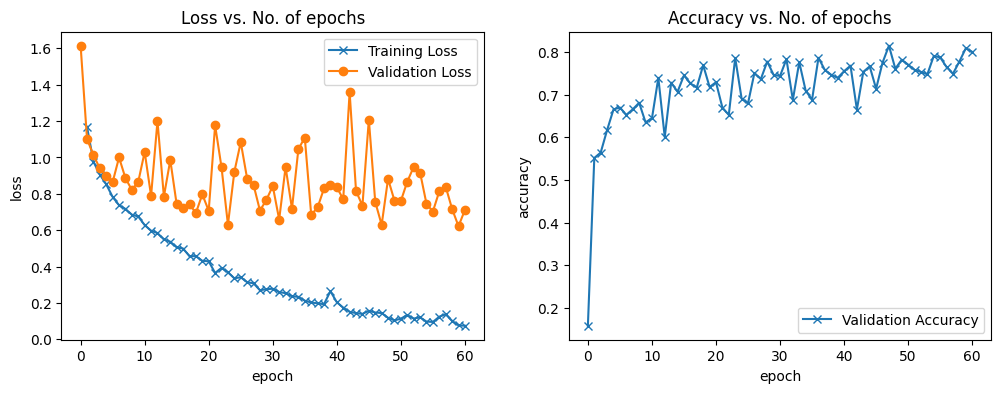

In [77]:
plot_history(history_transfer_padang)

In [76]:
history_transfer_padang_test = [evaluate(model_transfer_padang, test_dl_transfer_padang)]
print(history_transfer_padang_test)

[{'val_loss': 0.6799218058586121, 'val_acc': 0.8137176036834717}]


In [78]:
model_transfer_padang

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Modifying linear layer for Indonesian Cuisine transfer learning

In [79]:
model_transfer_padang.fc1 = nn.Linear(512, 9)
model_transfer_padang
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_transfer_padang = model_transfer_padang.to(device)


In [80]:
model_transfer_padang

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Setting up Indonesian dataset for transfer learning

In [81]:
data_dir_transfer_padang_process = "/kaggle/input/padangfood/dataset_padang_food"

dataset_transfer_padang_process = ImageFolder(root=data_dir_transfer_padang_process, transform=transform)
train_size_transfer_padang_process = int(0.7 * len(dataset_transfer_padang_process))
val_size_transfer_padang_process = int(0.15 * len(dataset_transfer_padang_process))
test_size_transfer_padang_process = len(dataset_transfer_padang_process) - train_size_transfer_padang_process - val_size_transfer_padang_process

train_ds_transfer_padang_process, val_ds_transfer_padang_process, test_ds_transfer_padang_process = random_split(dataset_transfer_padang_process, [train_size_transfer_padang_process, val_size_transfer_padang_process, test_size_transfer_padang_process])

from torch.utils.data import DataLoader

batch_size = 64

train_dl_transfer_padang_process = DataLoader(train_ds_transfer_padang_process, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl_transfer_padang_process = DataLoader(val_ds_transfer_padang_process, batch_size, num_workers=3, pin_memory=True)
test_dl_transfer_padang_process = DataLoader(test_ds_transfer_padang_process, batch_size, num_workers=3, pin_memory=True)

In [82]:
for inputs, targets in train_dl_transfer_padang_process:
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    
for inputs, targets in test_dl_transfer_padang_process:
    inputs = inputs.to(device)
    targets = targets.to(device)

for inputs, targets in val_dl_transfer_padang_process:
    inputs = inputs.to(device)
    targets = targets.to(device)

Using model trained on flowers to Indonesian cuisine dataset

In [83]:
history_transfer_padang_process = [evaluate(model_transfer_padang, val_dl_transfer_padang_process)]
history_transfer_padang_process

[{'val_loss': 2.3642091751098633, 'val_acc': 0.10104166716337204}]

In [84]:
epochs_transfer_padang_process = 60
max_lr_transfer_padang_process = 0.001
opt_func_transfer_padang_process = torch.optim.Adam

Training learned model on indonesian food dataset

In [85]:
history_transfer_padang_process += fit(epochs_transfer_padang_process, max_lr_transfer_padang_process, model_transfer_padang, train_dl_transfer_padang_process, val_dl_transfer_padang_process, opt_func_transfer_padang_process)

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.9385, val_loss: 12.8938, val_acc: 0.1927


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.6260, val_loss: 6.0786, val_acc: 0.2979


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.4954, val_loss: 1.6106, val_acc: 0.4688


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.3614, val_loss: 1.4078, val_acc: 0.5156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.3554, val_loss: 1.8355, val_acc: 0.4042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.2694, val_loss: 2.1614, val_acc: 0.3615


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1803, val_loss: 1.2266, val_acc: 0.5521


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.0411, val_loss: 1.4776, val_acc: 0.4719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.9858, val_loss: 1.4455, val_acc: 0.4458


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.0047, val_loss: 1.0016, val_acc: 0.6073


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.9714, val_loss: 1.3899, val_acc: 0.4823


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.9145, val_loss: 1.6703, val_acc: 0.5344


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.8622, val_loss: 1.4950, val_acc: 0.5177


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7888, val_loss: 2.3787, val_acc: 0.4448


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.7789, val_loss: 1.1233, val_acc: 0.6427


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.7541, val_loss: 1.3330, val_acc: 0.5208


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.7324, val_loss: 1.7116, val_acc: 0.5031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6493, val_loss: 1.4180, val_acc: 0.5531


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.6035, val_loss: 1.1477, val_acc: 0.6281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5471, val_loss: 1.1740, val_acc: 0.6219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.5257, val_loss: 1.3973, val_acc: 0.5792


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4652, val_loss: 2.3146, val_acc: 0.4448


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4730, val_loss: 1.1171, val_acc: 0.6094


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4535, val_loss: 1.2883, val_acc: 0.6042


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4136, val_loss: 0.9695, val_acc: 0.6521


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.3998, val_loss: 1.1616, val_acc: 0.6333


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.3336, val_loss: 0.9439, val_acc: 0.6365


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.3088, val_loss: 1.0901, val_acc: 0.6854


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.2745, val_loss: 1.0696, val_acc: 0.6385


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.3392, val_loss: 0.9900, val_acc: 0.6677


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.3270, val_loss: 2.4583, val_acc: 0.5469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.3531, val_loss: 1.5289, val_acc: 0.6135


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.3267, val_loss: 1.5019, val_acc: 0.5896


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.3710, val_loss: 1.3841, val_acc: 0.6135


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.2877, val_loss: 1.0780, val_acc: 0.6906


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2168, val_loss: 1.1009, val_acc: 0.6740


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.2163, val_loss: 1.4871, val_acc: 0.6167


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2241, val_loss: 0.9125, val_acc: 0.7188


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.1931, val_loss: 0.8586, val_acc: 0.7271


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.1717, val_loss: 0.8269, val_acc: 0.7760


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.1552, val_loss: 0.9184, val_acc: 0.7333


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.1267, val_loss: 0.8953, val_acc: 0.7281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.1381, val_loss: 0.9743, val_acc: 0.7490


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1467, val_loss: 1.1215, val_acc: 0.6906


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1522, val_loss: 0.7606, val_acc: 0.7823


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1403, val_loss: 2.0937, val_acc: 0.5729


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1917, val_loss: 2.3581, val_acc: 0.5302


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1533, val_loss: 1.4009, val_acc: 0.6677


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1127, val_loss: 1.0987, val_acc: 0.7240


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1253, val_loss: 1.4826, val_acc: 0.6385


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.0994, val_loss: 1.8963, val_acc: 0.5573


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.1005, val_loss: 0.8600, val_acc: 0.7438


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.1058, val_loss: 1.1171, val_acc: 0.7271


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.0758, val_loss: 0.9710, val_acc: 0.7396


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.1122, val_loss: 0.9753, val_acc: 0.7625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.0951, val_loss: 1.1018, val_acc: 0.7188


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.0805, val_loss: 1.0255, val_acc: 0.7135


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.0654, val_loss: 0.7182, val_acc: 0.8031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0788, val_loss: 1.3664, val_acc: 0.7188


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0612, val_loss: 0.8598, val_acc: 0.7719


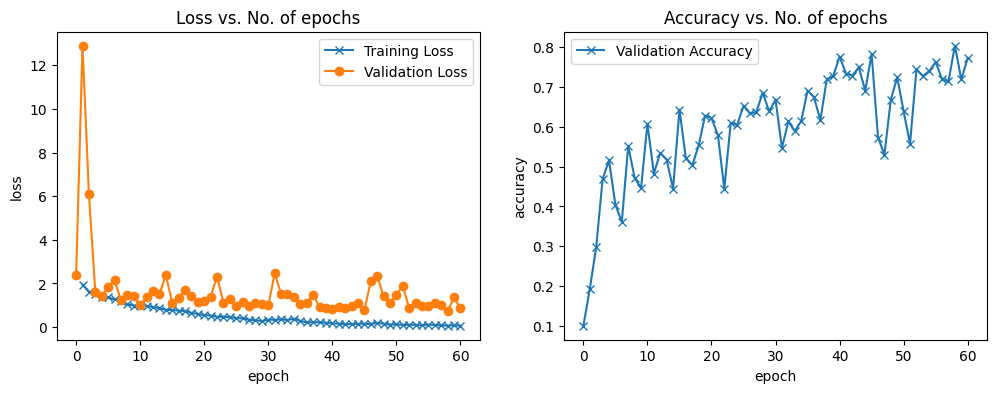

In [88]:
plot_history(history_transfer_padang_process)

In [87]:
history_test_transfer_padang_process = [evaluate(model_transfer_padang, test_dl_transfer_padang_process)]
history_test_transfer_padang_process

[{'val_loss': 0.8843731880187988, 'val_acc': 0.8243371844291687}]

Transfer learning from flowers to fruits

In [23]:
data_dir_transfer_veg = "./flowers-recognition/flowers"


dataset_transfer_veg = ImageFolder(root=data_dir_transfer_veg, transform=transform)

Setting up Flowers dataset

In [24]:
random_seed = 43
torch.manual_seed(random_seed)

val_pct_transfer_veg = 0.15
test_pct_transfer_veg = 0.15
val_size_transfer_veg = int(val_pct_transfer_veg * len(dataset_transfer_veg))
test_size_transfer_veg = int(test_pct_transfer_veg * len(dataset_transfer_veg))
train_size_transfer_veg = len(dataset_transfer_veg) - val_size_transfer_veg - test_size_transfer_veg
train_ds_transfer_veg, valid_ds_transfer_veg, test_ds_transfer_veg = random_split(dataset_transfer_veg, [train_size_transfer_veg, val_size_transfer_veg, test_size_transfer_veg])
len(train_ds_transfer_veg), len(valid_ds_transfer_veg), len(test_ds_transfer_veg)
from torch.utils.data import DataLoader

batch_size = 64

train_dl_transfer_veg = DataLoader(train_ds_transfer_veg, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl_transfer_veg = DataLoader(valid_ds_transfer_veg, batch_size, num_workers=3, pin_memory=True)
test_dl_transfer_veg = DataLoader(valid_ds_transfer_veg, batch_size, num_workers=3, pin_memory=True)

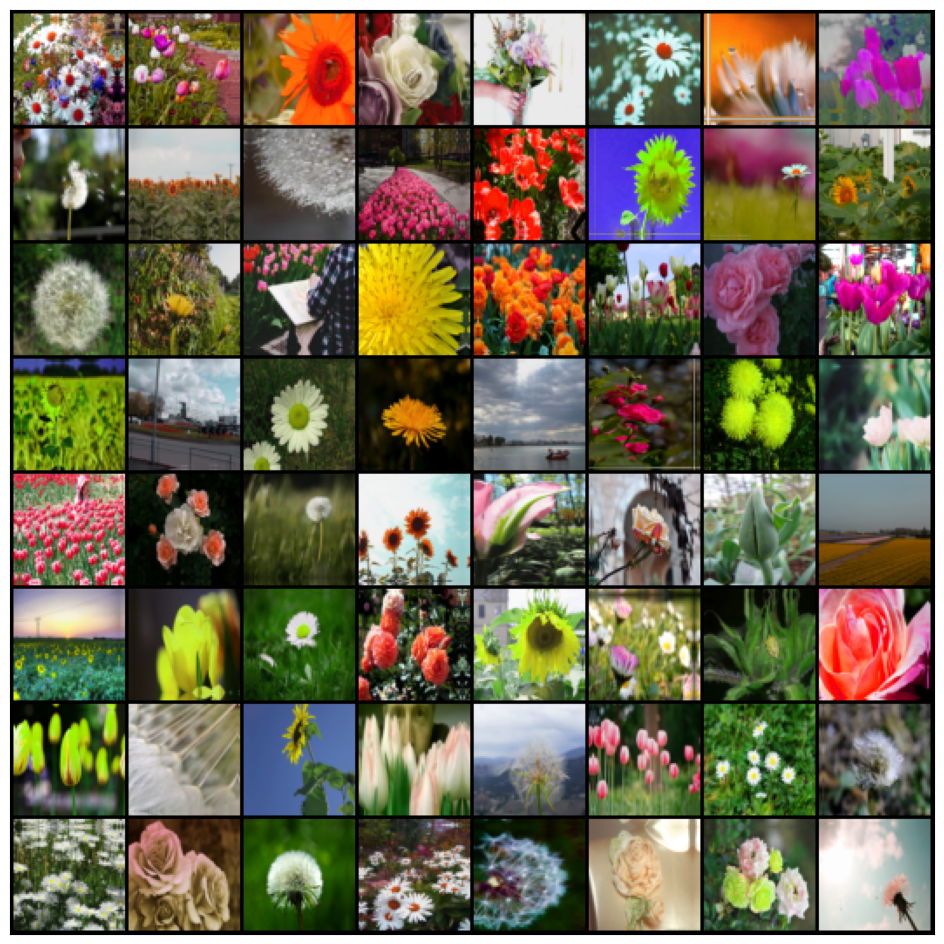

In [25]:
show_batch(train_dl_transfer_veg)

In [26]:
train_dl_transfer_veg = DeviceDataLoader(train_dl_transfer_veg, get_default_device())
valid_dl_transfer_veg = DeviceDataLoader(valid_dl_transfer_veg, get_default_device())
test_dl_transfer_veg = DeviceDataLoader(test_dl_transfer_veg, get_default_device())

In [34]:
model_transfer_veg = to_device(base_model(3, 5), device)
model_transfer_veg

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Initial training on flowers dataset

In [35]:
epochs_transfer_veg = 60
max_lr_transfer_veg = 0.0001
opt_func_transfer_veg = torch.optim.Adam

In [36]:
history_transfer_veg = [evaluate(model_transfer_veg, valid_dl_transfer_veg)]
history_transfer_veg

[{'val_loss': 1.6099189519882202, 'val_acc': 0.22362013161182404}]

Training new model on flowers dataset(will be used for the fruits dataset)

In [37]:
history_transfer_veg += fit(epochs_transfer_veg, max_lr_transfer_veg, model_transfer_veg, train_dl_transfer_veg, valid_dl_transfer_veg, opt_func_transfer_veg)

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1910, val_loss: 1.1754, val_acc: 0.5120


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9943, val_loss: 0.9923, val_acc: 0.5986


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9024, val_loss: 0.8951, val_acc: 0.6715


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8494, val_loss: 1.0523, val_acc: 0.5970


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8156, val_loss: 1.1395, val_acc: 0.5988


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7647, val_loss: 0.8564, val_acc: 0.6684


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7372, val_loss: 0.8754, val_acc: 0.6627


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7024, val_loss: 0.9600, val_acc: 0.6429


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6670, val_loss: 0.9516, val_acc: 0.6370


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6402, val_loss: 0.8473, val_acc: 0.6869


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6191, val_loss: 1.0818, val_acc: 0.6002


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5778, val_loss: 0.7696, val_acc: 0.7039


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5631, val_loss: 0.8162, val_acc: 0.7098


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5294, val_loss: 0.9374, val_acc: 0.6741


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5131, val_loss: 0.8610, val_acc: 0.6954


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4873, val_loss: 0.9735, val_acc: 0.6887


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4943, val_loss: 0.7293, val_acc: 0.7321


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4864, val_loss: 0.7451, val_acc: 0.7437


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4455, val_loss: 0.9764, val_acc: 0.6698


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4114, val_loss: 0.7455, val_acc: 0.7595


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4263, val_loss: 0.7069, val_acc: 0.7453


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3772, val_loss: 0.8373, val_acc: 0.6895


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.3925, val_loss: 0.7169, val_acc: 0.7640


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.3535, val_loss: 1.3121, val_acc: 0.6372


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.3435, val_loss: 1.0267, val_acc: 0.6569


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.3176, val_loss: 0.7570, val_acc: 0.7439


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.3254, val_loss: 0.9032, val_acc: 0.7070


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.3049, val_loss: 0.7489, val_acc: 0.7451


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.3014, val_loss: 0.7986, val_acc: 0.7526


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.2937, val_loss: 0.8339, val_acc: 0.7082


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.2612, val_loss: 1.2098, val_acc: 0.6698


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.2872, val_loss: 0.8720, val_acc: 0.7252


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.2453, val_loss: 0.8484, val_acc: 0.7181


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.2381, val_loss: 0.9524, val_acc: 0.7397


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.2464, val_loss: 0.8583, val_acc: 0.7380


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2189, val_loss: 1.0095, val_acc: 0.7139


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.2235, val_loss: 0.6597, val_acc: 0.7752


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2251, val_loss: 0.6488, val_acc: 0.7995


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2122, val_loss: 0.7253, val_acc: 0.7735


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2396, val_loss: 0.9723, val_acc: 0.7208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.1794, val_loss: 1.0859, val_acc: 0.7267


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.1590, val_loss: 0.9919, val_acc: 0.7041


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.1703, val_loss: 0.8644, val_acc: 0.7581


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1453, val_loss: 0.7714, val_acc: 0.7853


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1571, val_loss: 0.7838, val_acc: 0.7839


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1670, val_loss: 0.6187, val_acc: 0.7936


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1630, val_loss: 0.8520, val_acc: 0.7466


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1316, val_loss: 1.0345, val_acc: 0.7496


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1456, val_loss: 0.7584, val_acc: 0.7823


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1199, val_loss: 0.7386, val_acc: 0.7780


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.1078, val_loss: 0.8637, val_acc: 0.7754


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.1034, val_loss: 0.8050, val_acc: 0.7924


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.1364, val_loss: 0.8078, val_acc: 0.7679


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.1190, val_loss: 0.9452, val_acc: 0.7236


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.0975, val_loss: 1.0311, val_acc: 0.7066


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.0771, val_loss: 0.7591, val_acc: 0.7792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.0858, val_loss: 1.0276, val_acc: 0.7683


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.0976, val_loss: 0.7379, val_acc: 0.8036


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.1013, val_loss: 0.9208, val_acc: 0.7711


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0947, val_loss: 0.7275, val_acc: 0.7821


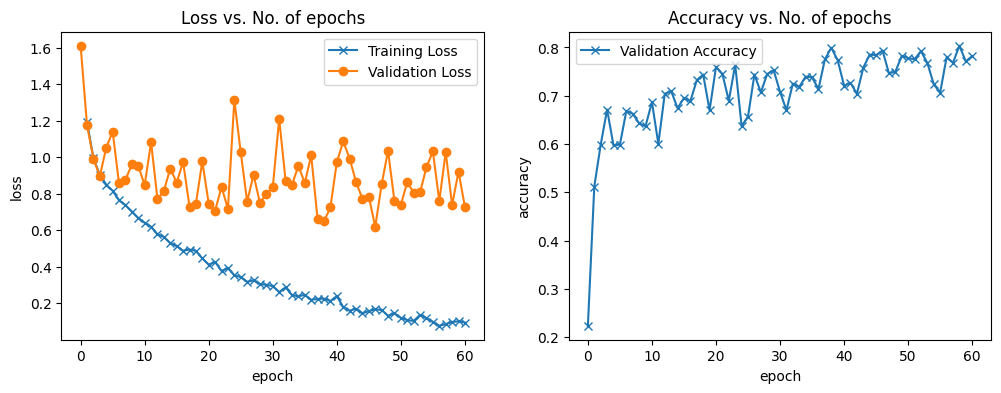

In [38]:
plot_history(history_transfer_veg)

In [39]:
history_transfer_test_veg_process = [evaluate(model_transfer_veg, test_dl_transfer_veg)]
history_transfer_test_veg_process

[{'val_loss': 0.720207691192627, 'val_acc': 0.8021509647369385}]

In [40]:
model_transfer_veg

base_model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c

Modifying linear layer for fruit transfer learning

In [41]:
model_transfer_veg.fc1 = nn.Linear(512, 9)
model_transfer_veg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_transfer_veg = model_transfer_veg.to(device)

Setting up fruits database for transferral process

In [42]:
data_dir_transfer_veg_process = "/kaggle/input/fruits-dataset-images/images"
dataset_transfer_veg_process = ImageFolder(root=data_dir_transfer_veg_process, transform=transform)
train_size_transfer_veg_process = int(0.7 * len(dataset_transfer_veg_process))
val_size_transfer_veg_process = int(0.15 * len(dataset_transfer_veg_process))
test_size_transfer_veg_process = len(dataset_transfer_veg_process) - train_size_transfer_veg_process - val_size_transfer_veg_process

train_ds_transfer_veg_process, val_ds_transfer_veg_process, test_ds_transfer_veg_process = random_split(dataset_transfer_veg_process, [train_size_transfer_veg_process, val_size_transfer_veg_process, test_size_transfer_veg_process])

from torch.utils.data import DataLoader

batch_size = 64

train_dl_transfer_veg_process = DataLoader(train_ds_transfer_veg_process, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl_transfer_veg_process = DataLoader(val_ds_transfer_veg_process, batch_size, num_workers=3, pin_memory=True)
test_dl_transfer_veg_process = DataLoader(test_ds_transfer_veg_process, batch_size, num_workers=3, pin_memory=True)

In [43]:
for inputs, targets in train_dl_transfer_veg_process:
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    
for inputs, targets in test_dl_transfer_veg_process:
    inputs = inputs.to(device)
    targets = targets.to(device)

for inputs, targets in val_dl_transfer_veg_process:
    inputs = inputs.to(device)
    targets = targets.to(device)

Training and testing model trained on flowers to fruits dataset

In [44]:
history_transfer_veg_process = [evaluate(model_transfer_veg, val_dl_transfer_veg_process)]
history_transfer_veg_process

[{'val_loss': 2.495516538619995, 'val_acc': 0.09433962404727936}]

In [45]:
epochs_transfer_veg_process = 60
max_lr_transfer_veg_process = 0.0001
opt_func_transfer_veg_process = torch.optim.Adam

Training and testing model trained on flowers to fruits dataset

In [46]:
history_transfer_veg_process += fit(epochs_transfer_veg_process, max_lr_transfer_veg_process, model_transfer_veg, train_dl_transfer_veg_process, val_dl_transfer_veg_process, opt_func_transfer_veg_process)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.2094, val_loss: 1.8296, val_acc: 0.4717


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.6662, val_loss: 1.6682, val_acc: 0.3962


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.4315, val_loss: 1.5397, val_acc: 0.4528


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.2294, val_loss: 1.4268, val_acc: 0.4340


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.0622, val_loss: 1.5329, val_acc: 0.5094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.9220, val_loss: 1.3975, val_acc: 0.5849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.8270, val_loss: 1.2127, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7811, val_loss: 1.2154, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6176, val_loss: 1.1654, val_acc: 0.5849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5695, val_loss: 1.1616, val_acc: 0.5849


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4838, val_loss: 1.2876, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4500, val_loss: 0.9505, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.3737, val_loss: 1.1128, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.3496, val_loss: 1.1605, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.3238, val_loss: 1.0833, val_acc: 0.6792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.2458, val_loss: 1.0418, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.2622, val_loss: 0.8345, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.2388, val_loss: 0.9062, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.2024, val_loss: 1.3437, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1786, val_loss: 1.0512, val_acc: 0.6792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.1851, val_loss: 1.0529, val_acc: 0.6792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.1597, val_loss: 0.8135, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.1684, val_loss: 0.8283, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.1232, val_loss: 1.0557, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.1644, val_loss: 1.0942, val_acc: 0.6792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.0953, val_loss: 0.8316, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.1065, val_loss: 0.8787, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0938, val_loss: 1.0434, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0797, val_loss: 0.7196, val_acc: 0.7736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0715, val_loss: 1.0452, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0602, val_loss: 1.1578, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0630, val_loss: 1.0809, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0614, val_loss: 0.9189, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0467, val_loss: 1.0485, val_acc: 0.6792


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0437, val_loss: 1.0699, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0598, val_loss: 0.8679, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0519, val_loss: 0.7640, val_acc: 0.7736


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0451, val_loss: 0.9556, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0432, val_loss: 0.9653, val_acc: 0.7547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0469, val_loss: 0.9985, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0446, val_loss: 0.9632, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0270, val_loss: 1.0256, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0347, val_loss: 0.8573, val_acc: 0.6981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0264, val_loss: 0.9336, val_acc: 0.7547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0523, val_loss: 0.8930, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0362, val_loss: 0.9381, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0335, val_loss: 1.0168, val_acc: 0.6226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0328, val_loss: 0.9575, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0352, val_loss: 1.1581, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0413, val_loss: 0.9774, val_acc: 0.8113


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.0242, val_loss: 1.2750, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.0362, val_loss: 1.0861, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.0328, val_loss: 1.1904, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.0372, val_loss: 1.1014, val_acc: 0.6604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.0287, val_loss: 0.8947, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.0208, val_loss: 1.0661, val_acc: 0.7170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.0217, val_loss: 1.1214, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.0218, val_loss: 1.0245, val_acc: 0.7358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0201, val_loss: 1.1605, val_acc: 0.6415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0186, val_loss: 0.9516, val_acc: 0.6981


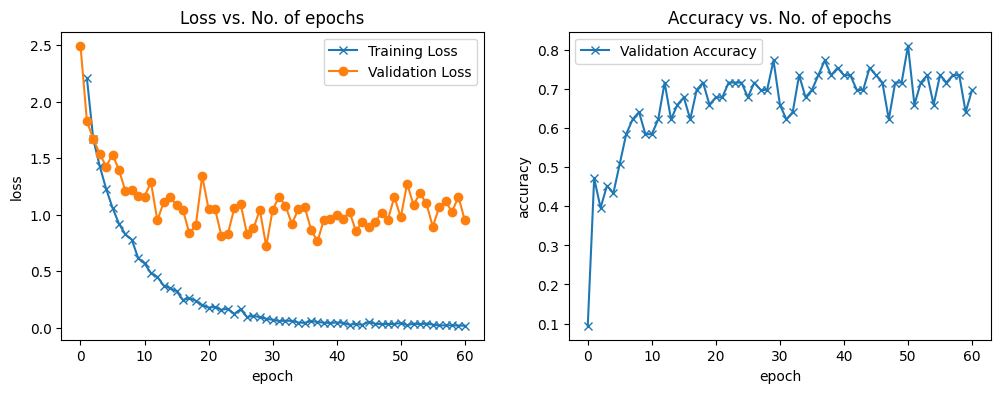

In [47]:
plot_history(history_transfer_veg_process)

In [49]:
history_transfer_veg_process_test = [evaluate(model_transfer_veg, test_dl_transfer_veg_process)]
history_transfer_veg_process_test

[{'val_loss': 1.1031497716903687, 'val_acc': 0.7090908885002136}]